# What?
In this notebook we will discuss about some topics on model selection in the presence of imabalanced datasets. The discussion can be guided by the following driving questions:
* What is the effect of class imbalance on different classification algorithms?
* Is class imbalance really a problem when there is enough data?
* What is the best benchmark model to start with? What does "best" actually mean in this situation?
* What can be done to mitigate the effect of imbalance on specific algorithms?

## How?
We intend to analyze the behavior (using some classification metrics) of different classification models under various imbalance scenarios
At this point we won't pay too much attention on the optimization of the models themselves. Rather, we will work with the model 'as-is' and compare them with the objective of finding the *best* benchmarking model.

# Imports

In [24]:
# basics
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Any, List, Dict
from tqdm.auto import tqdm

# plotting
import matplotlib
import plotly.express as px
from matplotlib import pyplot as plt

# sklearn
from sklearn.datasets import make_classification

# Auxiliary Functions

In [12]:
def bootstrap_samples(y_true: List, y_pred: List, n_batches: int = 100) -> List:
    """Get bootstrap samples

    Parameters
    ----------

    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_batches : int, optinal
        number of bootstrap samples, default = 100

    Returns
    -------

    preds_samples : array_like, shape = [n_samples, [n_batches, 2]]
        list of bootstrap samples from y_true and y_preds
    """
    # y_true = pd.Series(y_true, name='y_true')
    # y_pred = pd.Series(y_pred, name='y_pred')
    # df_preds = pd.concat((y_true, y_pred), axis=1)
    df_preds = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    n_samples = len(y_true)
    preds_samples = []
    for i in np.arange(n_batches):

        df_preds_resample = df_preds.sample(n_samples, replace=True)

        y_true_resample = df_preds_resample['y_true'].values
        y_pred_resample = df_preds_resample['y_pred'].values

        preds_samples.append({'y_true': y_true_resample,
                              'y_pred': y_pred_resample})

    preds_samples = preds_samples

    return preds_samples

In [13]:
def delinquency_curve(y_true, y_score, pointwise=True):
    """ Delinquency curve.

    The delinquency curve is curve that shows the default rate in function of
    the approval rate. With this curve is possible to have a clear view of a
    credit operation and its characteristics for all possible scenarios.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        Correct labels for given dataset.

    y_score : array, shape = [n_samples]
        Predict scores for the given dataset.

    pointwise : bool, optional
        boolean indicating whether to compute pointwise delinquency curve.

    Returns
    -------
    approval_rate: array, shape = [n_samples+1] if pointwise=True else [21]
        Array containing the approval rates used to compute the default_rate
        curve.
    default_rate: array, shape = [n_samples+1] if pointwise=True else [21]
        Default rate values for the approval rates provided in approval_rate.
        default_rate[i] is the ratio of events registered in the best
        approval_rate[i]% of scores.

    """
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    assert len(y_true) == len(y_score), F"y_true and y_score doesn't have " \
        F"the same length. len(y_true) = " \
        F"{len(y_true)}, len(y_score) = " \
        F"{len(y_score)}"

    indexsort = np.argsort(y_score)[::-1]
    y_approved = y_true[indexsort].copy()

    if pointwise:
        list_index = np.arange(1, len(y_approved)+1)
        approval_rate = np.append(0, list_index/len(list_index))
        default_rate = np.append(0, y_approved.cumsum()/list_index)
    else:
        approval_rate = np.linspace(0, 1, 21)
        n = len(y_true)

        default_rate = np.array([y_approved[:int(np.floor(i * n))].mean()
                                 if (y_approved[:int(np.floor(i * n))]
                                     .size)
                                 else 0 for i in approval_rate])
    return approval_rate, default_rate

In [14]:
def compute_metrics(y_true: List, y_proba: List, n_round: int = 2) -> pd.DataFrame:
    """Computes several classification metrics at once
    Parameters
    ----------
    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_round : int, optional
        number o decimals to round gini and ks metrics
    Returns
    -------
    metrics: pd.DataFrame
    """
    metrics = {}
    # ROC AUC
    metrics['roc_auc'] = np.round(roc_auc_score(y_true, y_proba), n_round)
    # GINI
    metrics['gini'] = 2 * metrics['roc_auc'] - 1
    # Average precision
    metrics['avg_precision'] = np.round(average_precision_score(y_true, y_proba), n_round)
    # ROC Curve
    fpr, tpr, thresholds_roc = roc_curve(y_true = y_true, y_score = y_proba)
    metrics['roc_curve'] = {'fpr': fpr,
                            'tpr': tpr, 
                            'thresholds': thresholds_roc}
    # Precision-Recall curve
    precision, recall, thresholds_pr = precision_recall_curve(y_true = y_true, probas_pred = y_proba)
    metrics['pr_curve'] = {'precision' : precision,
                            'recall': recall,
                            'thresholds': thresholds_pr}
    # Delinquency curve
    d_curve_p = delinquency_curve(y_true = y_true, y_score = 1 - y_proba, pointwise= True)
    d_curve_agg = delinquency_curve(y_true = y_true, y_score = 1 - y_true, pointwise = False)
    metrics['d_curve_pointwise'] = d_curve_p
    metrics['d_curve_agg'] = d_curve_agg

    return metrics


In [15]:
def compute_metrics_bootstrap(y_true, y_pred, n_batches=100):
    """computes frequently used metrics from bootstramp samples

    Parameters
    ----------

    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_batches : int, optinal
        number of bootstrap samples, default = 100

    Returns
    -------

    metrics_summary : dict
        dictionary containig statistics of gini, ks, d_curve and c_curves
    """
    preds_samples = bootstrap_samples(y_true, y_pred, n_batches)

    df_metrics = pd.DataFrame([compute_metrics(y['y_true'],
                                                     y['y_pred'])
                              for y in preds_samples])

    approval_rate_p = df_metrics['d_curve_pointwise'].iloc[0][0]
    default_rate_mean_p = df_metrics['d_curve_pointwise'].apply(
        lambda x: x[1]).mean()
    default_rate_std_p = df_metrics['d_curve_pointwise'].apply(
        lambda x: x[1]).values.std()
    d_curve_mean_p = (approval_rate_p, default_rate_mean_p)
    d_curve_std_p = (approval_rate_p, default_rate_std_p)

    approval_rate_agg = df_metrics['d_curve_agg'].iloc[0][0]
    default_rate_mean_agg = df_metrics['d_curve_agg'].apply(
        lambda x: x[1]).mean()
    default_rate_std_agg = df_metrics['d_curve_agg'].apply(
        lambda x: x[1]).values.std()
    d_curve_mean_agg = (approval_rate_agg, default_rate_mean_agg)
    d_curve_std_agg = (approval_rate_agg, default_rate_std_agg)

    metrics_stats = df_metrics[['roc_auc',
                                'gini',
                                'avg_precision',
                                # 'ks'
                                ]].apply([np.mean, np.std])

    metrics_summary = {'d_curve_pointwise': {'d_curve_mean': d_curve_mean_p,
                                             'd_curve_std': d_curve_std_p},
                       'd_curve_agg': {'d_curve_mean': d_curve_mean_agg,
                                       'd_curve_std': d_curve_std_agg},
                       'metrics_stats': metrics_stats,
                       'df_metrics': df_metrics}
    return metrics_summary

In [16]:
def clean_ax(ax, all = False):
    """Clean spines of a matplotlib axis"""
    if all:
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)    
    ax.spines["top"].set_visible(False)
    return ax

# Data
We will write a function that generates synthetic binary classification data allowing for various class imbalance levels

In [17]:
def create_imbalanced_binary_classification(n_samples: int = 1000, 
                                            n_features: int = 4,
                                            n_informative: int = None, 
                                            imbalance: float = 0.1,
                                            random_state: int = 42,
                                            class_sep : float = 1.0) -> pd.DataFrame:
    """Creates an imbalanced dataset for binary classification
    Parameters
    ----------
    n_samples: int, default = 1000,
            number of samples to generate
    n_features: int default = 4,
            number of features (not all are informative)
    n_informative: int default = None,
            number of informative features
            if none is specified floor(n_features/2) 
            will be taken
    imbalance: float, default = 0.1
            proportion of the minority class
    random_state: int, default = 42
    class_sep: float, default = 1.0
        The larger the value the easier the classification task
    Returns
    -------
    data: pd.DataFrame,
        dataframe with n_features + 1 columns
    """
    if n_informative == None:
        n_informative = int(n_features/2)
    weights = [1 - imbalance, imbalance]
    X, y = make_classification(n_samples = n_samples,
                                n_features = n_features,
                                n_classes=2,
                                n_informative = n_informative,
                                weights = weights,                
                                random_state = random_state,
                                class_sep = class_sep)
    column_names = [ f'feature_{i}' for i in np.arange(n_features)]      
    data = pd.concat([pd.DataFrame(X, columns = column_names), pd.DataFrame(y, columns = ['target'])], axis = 1)
    return data, column_names

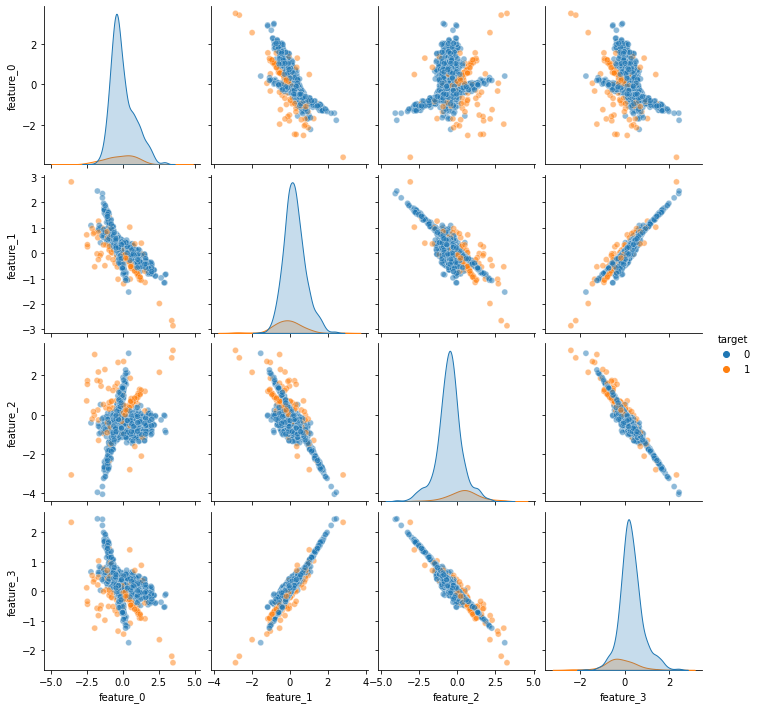

In [18]:
n_samples = 10**3
n_features = 4
imbalance = 0.1
n_informative = 2
class_sep = 0.5
data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance,
                                        class_sep = class_sep)
sns.pairplot(data, hue = 'target', plot_kws = {'alpha' : 0.5})


# Model comparison
In this section we will compare the performance (and other aspects) of different models under different class imbalance scenarios.
We will start by analyzing the performance dependence on the class imbalance index which we define as being the minority class ratio or *Prevalence*. If we call $P$ and $N$ the number of positive and negative observations, the prevalance is given by:
$$\nu := \dfrac{P}{P+N}.$$
The main parameter to be explored is $\nu$, going from an equal-class setup to a highly imbalanced scenario where there really few examples of the minority class.

The first simple analysis is to be made upon the performance impact of the imbalance in classes for several algorithms. At this point we are interested in answering a simple practical question:

In order to center text in md files you can use the center tag like html tag:

<center><span style="background-color: blue">What is the best benchmark algorithm in the presence of class imbalance?</span></center>


To answer this question we might be interested in looking at other aspects of the statistical learning process aside of the classification performance metrics, such as: 
* Sample Size
* Fit Time
* Model complexity

In [96]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, matthews_corrcoef,  precision_recall_curve,\
                            average_precision_score, f1_score, auc


## Performance Impact
Let us see how the performance changes for different imbalance ratios:

In [25]:
n_samples = 10**5
n_features = 4
n_informative = 2
class_sep = 0.5
metrics = {}
fit_time = {}
imbalances = [0.5, 0.3, 0.2, 0.1, 0.05, 0.01, 5e-3, 1e-4]
random_state = 42
for imbalance in tqdm(imbalances):
    print(f'Minority class proportion: {imbalance}')
    metrics[imbalance] = {}
    # Create dataset
    data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance,
                                        class_sep = class_sep)
    # Train test split
    X, y = data[column_names], data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, stratify = y)
    
    # Logistic Regression
    print('\tLog Regression ...')
    lr_pipeline = Pipeline([('scaler', StandardScaler()),
                            ('logreg', LogisticRegression())])
    lr_pipeline.fit(X_train, y_train)
    y_proba_lr = lr_pipeline.predict_proba(X_test)
    # metrics[imbalance]['logreg'] = compute_metrics(y_true = y_test, y_proba = y_proba_lr[:,1])
    metrics[imbalance]['logreg'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_lr[:,1])
    
    # Decision Tree
    print('\tDecision Tree ...')
    dt_clf = DecisionTreeClassifier()
    dt_clf.fit(X_train, y_train)
    y_proba_dt = dt_clf.predict_proba(X_test)
    # metrics[imbalance]['dt'] = compute_metrics(y_true = y_test, y_proba= y_proba_dt[:,1])
    metrics[imbalance]['dt'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_dt[:,1])

    # Random Forest
    print('\tRandom Forest ...')
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    y_proba_rf = rf_clf.predict_proba(X_test)
    metrics[imbalance]['rf'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_rf[:,1])

    # Naive Bayes
    print('\tNaive Bayes ...')
    nb_clf = RandomForestClassifier()
    nb_clf.fit(X_train, y_train)
    y_proba_nb = nb_clf.predict_proba(X_test)
    metrics[imbalance]['nb'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_nb[:,1])

    # Gradient Boosting Machine
    print('\tGradient Boosting ...')
    gb_clf = HistGradientBoostingClassifier()
    gb_clf.fit(X_train, y_train)
    y_proba_gb = gb_clf.predict_proba(X_test)
    metrics[imbalance]['gb'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_gb[:,1])

    # Dummy Classifier
    print('\tDummy Classifier ...')
    dummy_clf = DummyClassifier()
    dummy_clf.fit(X_train, y_train)
    y_proba_dummy = dummy_clf.predict_proba(X_test)
    metrics[imbalance]['dummy'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_dummy[:,1])

    # # SVM Classifier
    # print('Support Vector Machine ...')
    # svm_pipeline = Pipeline([('scaler', StandardScaler()),
    #                         ('svc', SVC(gamma = 'auto',
    #                                     probability= True))])
    # svm_pipeline.fit(X_train, y_train)
    # y_proba_svm = svm_pipeline.predict_proba(X_test)
    # metrics[imbalance]['svm'] = compute_metrics_bootstrap(y_true= y_test, y_pred = y_proba_svm[:,1])

print('end')

  0%|          | 0/8 [00:00<?, ?it/s]

Minority class proportion: 0.5
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 12%|█▎        | 1/8 [00:57<06:39, 57.05s/it]

Minority class proportion: 0.3
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 25%|██▌       | 2/8 [01:55<05:48, 58.14s/it]

Minority class proportion: 0.2
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 38%|███▊      | 3/8 [02:58<04:59, 59.96s/it]

Minority class proportion: 0.1
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 50%|█████     | 4/8 [04:02<04:07, 61.84s/it]

Minority class proportion: 0.05
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 62%|██████▎   | 5/8 [05:09<03:10, 63.49s/it]

Minority class proportion: 0.01
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 75%|███████▌  | 6/8 [06:15<02:09, 64.56s/it]

Minority class proportion: 0.005
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 88%|████████▊ | 7/8 [07:20<01:04, 64.51s/it]

Minority class proportion: 0.0001
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


100%|██████████| 8/8 [08:08<00:00, 61.09s/it]

end


In [21]:
def plot_metric_evolution(metrics: Dict, 
                          model_name: str,
                          metric_4_display: str = 'roc_auc',
                          color: str = 'purple', 
                          ax: matplotlib.axis = None) -> matplotlib.axis:
    """
    Plots the imbalance-evolution of classification metrics

    """
    labels = {'logreg': 'Logistic Regression',
              'dt': 'Decision Tree',
              'rf': 'Random Forest',
              'nb': 'Naive Bayes',
              'gb': 'Gradient Boosting',
              'dummy': 'Dummy Classifier' }
    if ax == None:
        f, ax = plt.subplots(dpi = 100)
    metrics_mean = [metrics[x][model_name]['metrics_stats'][metric_4_display]['mean'] for x in metrics.keys()]
    metrics_std = [metrics[x][model_name]['metrics_stats'][metric_4_display]['std'] for x in metrics.keys()]
    x = range(len(metrics.keys()))
    ax.plot(metrics_mean, marker = '.', linestyle = '--',
            color = color, label = labels[model_name],
            alpha = 0.6)
    ax.fill_between(x = x, 
                    y1 = np.subtract(metrics_mean, metrics_std), 
                    y2 =np.add(metrics_mean, metrics_std),
                    alpha = 0.3, facecolor = color)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics.keys())
    ax.set_xlabel('Minority class proportion')
    return ax

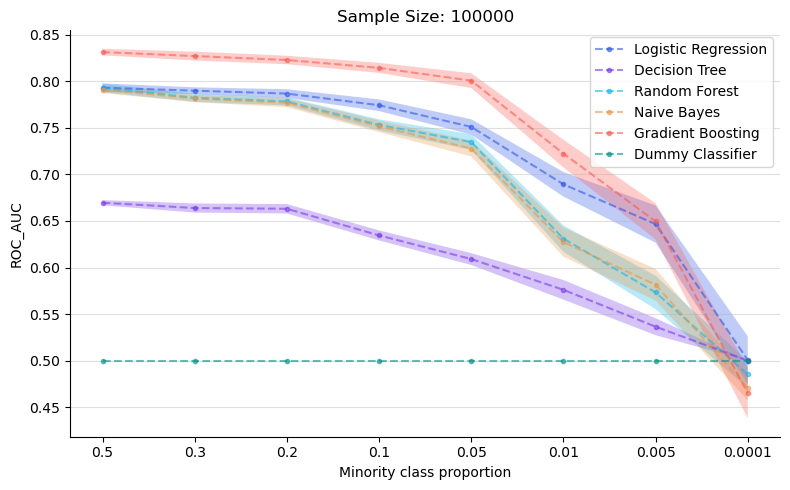

In [22]:
metric_4_display = 'roc_auc'
colors = {'logreg': '#2F58EB',
          'dt': '#773BEB',
          'rf': '#12B8EB',
          'nb': '#EB9846',
          'gb': '#FC5A50',
          'dummy': '#029386'}
f, ax = plt.subplots(dpi = 100, figsize = (8,5))
for model_name, color in colors.items():
    plot_metric_evolution(metrics, model_name, metric_4_display= metric_4_display, color = color, ax = ax)
ax.legend(loc = 'best')
ax.grid(True, axis = 'y', alpha = 0.4)
ax.set_ylabel(metric_4_display.upper())
ax.set_title(f'Sample Size: {n_samples}')
clean_ax(ax)
f.tight_layout()

Let us plot the evolution of ROC and PR curves. We will first fix the imbalance ratio and plot the curves for all models under comparison. 
Since the metrics were computed for bootstrapped samples of predictions we will actually plot the mean ROC and PR curves. The computation of these mean curves must be taken with care since an intermediate interpolation step is carried out for the mean curve calculation. In particular, the interpolation between two points in PR space might not be linear, see section 4 in [The Relationship between Precision-Recall and ROC curves](https://www.biostat.wisc.edu/~page/rocpr.pdf). This interpolation procedure will be revisited in the near future.

Then we can vary the imbalance ratio $\nu$ to see the evolution of the ROC and PR curves.


In [140]:
def plot_roc_curve(df_metrics: pd.DataFrame,
                    color: str = 'purple',
                    label : str = None, 
                    ax : matplotlib.axis = None) -> matplotlib.axis:
    """plots the roc curve for a bootstrapped confidence interval
    Parameters
    ----------
    df_metrics: pd.DataFrame
        dataframe that holds the roc curves for each boostrap sample
    label: str, (default = None)
    axis: matplotlib.axis (default = None)
    Returns
    -------
    ax: matplotlib.axis
    """
    assert isinstance(df_metrics, pd.DataFrame), 'df_metrics has to be a dataframe object!'
    if ax == None:
        f, ax = plt.subplots(dpi = 100)
    if label == None:
        label = 'mean ROC curve'
    # Define the mean false positive rate
    mean_fpr = np.linspace(0, 1, 100)
    # Interpolate the roc curves using the mean fpr values
    tprs = []
    for i in range(df_metrics.shape[0]):
        tpr = df_metrics['roc_curve'][i]['tpr']
        fpr = df_metrics['roc_curve'][i]['fpr']
        inter_tpr = np.interp(mean_fpr, fpr, tpr)
        inter_tpr[0] = 0.0
        tprs.append(inter_tpr)
        del inter_tpr
    mean_tpr = np.mean(tprs, axis = 0)
    std_tpr = np.std(tprs, axis = 0)
    ax.plot(mean_fpr, mean_tpr, 
        color = color, 
        label = label,
        linestyle = '--',
        alpha = 0.8)
    ax.fill_between(mean_fpr, 
                y1 = mean_tpr - std_tpr,
                y2 = mean_tpr + std_tpr,
                alpha = 0.12, facecolor = color)
    ax.legend(loc = 'best', frameon = False)
    return ax
    

In [117]:

def plot_pr_curve(df_metrics: pd.DataFrame,
                    color: str = 'purple',
                    label : str = None, 
                    ax : matplotlib.axis = None) -> matplotlib.axis:
    """plots the precisio-recall curve for a bootstrapped PR calculation
    Parameters
    ----------
    df_metrics: pd.DataFrame
        dataframe that holds the pr curves for each boostrapped sample
    label: str, (default = None)
    axis: matplotlib.axis (default = None)
    Returns
    -------
    ax: matplotlib.axis
    """
    assert isinstance(df_metrics, pd.DataFrame), 'df_metrics has to be a dataframe object!'
    if ax == None:
        f, ax = plt.subplots(dpi = 100)
    if label == None:
        label = 'mean PR curve'
    # Define the mean recall
    mean_recall = np.linspace(0, 1, 100)
    precisions = []
    aucs = []
    # Interpolate the precision curves
    for i in range(df_metrics.shape[0]):
        precision = df_metrics['pr_curve'].iloc[i]['precision']
        recall = df_metrics['pr_curve'].iloc[i]['recall']
        interp_precision = np.interp(x = mean_recall, xp = recall[::-1], fp = precision[::-1])
        precisions.append(interp_precision)
        pr_auc = auc(recall, precision)
        aucs.append(pr_auc)
    mean_precision = np.mean(precisions, axis = 0)
    std_precision = np.std(precisions, axis = 0)
    # Actual Plot
    ax.plot(mean_recall, mean_precision,
            color = color,
            label = label,
            linestyle = '--',
            alpha = 0.8)
    ax.fill_between(mean_recall, 
                    y1 = mean_precision - std_precision,
                    y2 = mean_precision + std_precision,
                    alpha = 0.12, facecolor = color)
    ax.legend(loc = 'best', frameon = False)
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    return ax

In [141]:
colors

{'logreg': '#2F58EB',
 'dt': '#773BEB',
 'rf': '#12B8EB',
 'nb': '#EB9846',
 'gb': '#FC5A50',
 'dummy': '#029386'}

Text(0.5, 0.98, 'LOGREG')

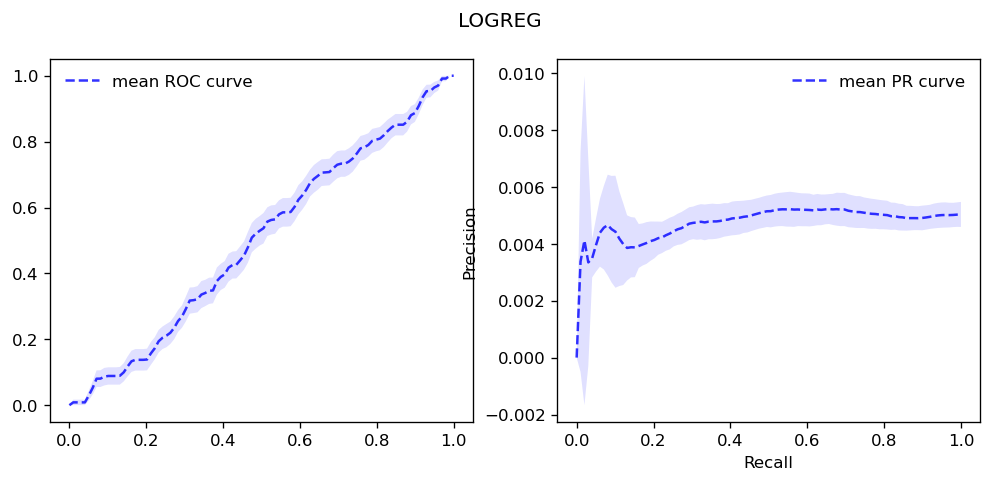

In [149]:
imbalance = 0.0001
model_name = 'logreg'
# f, ax = plt.subplots(len(colors), 2, dpi = 100, figsize = (10, 4*len(colors)))
# for axis, model_name  in zip(ax, colors.keys()):
#     print(axis, model_name)
df_metrics = metrics[imbalance][model_name]['df_metrics']
f, ax = plt.subplots(1,2, dpi = 120, figsize = (10,4))
plot_roc_curve(df_metrics, color = 'blue',
                ax = ax[0])
plot_pr_curve(df_metrics=df_metrics, color = 'blue', ax = ax[1])
f.suptitle(model_name.upper())

Now that we know how to plot the ROC and PR curves

## Sample Size effect

At first sight the Logistic Regression performance dependence on imbalance is very similar to the Gradient Boosting Machine, which makes the Logisitic Regression a good candidate for a benchmark model. What other quantities should we look at? 
* Training time
* model complexity

# Model selection section `v0`

In this section we will discuss the problem of model selection inside the imbalanced learning context. To begin the discussion let us introduce some general definitions of the binary classification problem.
In general terms, we are interested in extracting information about an **unknown** joint probability distribution $\text{Pr}(X,Y)$ of random variables $X, Y$ from which we got a sample $\mathcal{D} = \{(x_i, y_i)\}_{i = 1, \dots, n}$ (the dataset), with the random variable $Y$ taking values in $\{0,1\}$. 
The binary classification problem can be summarized as the problem of finding a function $f: X \longrightarrow \{0,1\}$ defined by:
$$f(x):= \mathbb{P}(Y=1 | X=x),$$
often called **score**. In practice, solving the classification problem implies using an **estimator** function $\hat{f}:X \longrightarrow [0,1]$. It is worth mentioning that the output of this estimator function is not to be interpreted as a probability, in general. A more detailed discussion will be given in the model calibration section.
The classification problem is not entirely solved by finding the best estimator function $\hat{f}$ since in general we could be actually interested in predicting the class to which a particular example belongs, this is, we are looking for an estimator:
$$\hat{y}_{\lambda}(x) = \begin{cases}
                1,\;\; \text{if } \hat{f}(x) \geq \lambda, \\ 
                0, \;\; \text{if } \hat{f}(x) < \lambda
            \end{cases}$$
In this terms, we can state the problem of **model selection** as trying to answer the following question:
> *What is the best estimator function* $\hat{f}: X \longrightarrow [0,1]$ *we can find?*

Note that there is a related question that we will try to solve (at the same time) related to the choice of the $\lambda$ threshold parameter.

In order to be able to compare different **estimators** or **models** we need a way to compare them, this can be done by looking at different criteria, namely:
* missclassification error or classification metrics
* model complexity and *bias-variance* tradeoff
* training time
* Sensitivity to class imbalance
* ...
  
Often, solving a binary classification problem involves optimizing the hyperparameters of inference models. This process can be both computationally intensive and time consuming. Thus, the gain in performance obtained by following this optimization procedure has to be worth  of performing. To this end, it is common to compare the resulting complex model with a most simple and interpretable model (usually logistic regression).

## Error estimation
There are different measures of missclassification errors and their use, in general, depend on the business problem and the characteristics of the joint probability distribution $\text{Pr}(X,Y)$ that we can access through a sample of this distribution $\mathcal{D}$.
Given a prediction model $\hat{f}: X \longrightarrow [0,1]$ whose paremeters were estimated by means of a training set $\mathcal{T}$. Consider also an error (loss) function $L: \{0,1\} \times [0,1] \longrightarrow \mathbb{R}_{+}$, such that the missclassification error of a predicted observation $\hat{y} = \hat{f}(x)$, where $x \sim X$ is denoted $L(y, \hat{y})$.